In [25]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

ground_truth_dir = os.path.join(
    'mall_dataset',
    'ground_truth'
)

images_dir = os.path.join(
    'mall_dataset',
    'frames'
)

ground_truth = scipy.io.loadmat(
    os.path.join(
        'mall_dataset',
        'mall_gt.mat'
    )
)

In [26]:
# Access the frame and count arrays
frame_array = ground_truth['frame']
count_array = ground_truth['count']

# Iterate over the elements in the frame array
for i, (frame, count) in enumerate(zip(frame_array[0], count_array.T[0])):
    # Create a new dictionary to mimic the structure of the first case
    mat_ground_truth = {
        '__header__': ground_truth['__header__'],
        '__version__': ground_truth['__version__'],
        '__globals__': ground_truth['__globals__'],
        'image_info': np.array([[
            np.array([(
                np.array([frame][0][0][0][0]),
                np.array([count][0])
            )], dtype=[('location', 'O'), ('number', 'O')])
        ]], dtype='O')
    }

    # Save each element as a separate mat file
    scipy.io.savemat(
        os.path.join(
            ground_truth_dir,
            f'GT_seq_{i+1:06d}.mat'
        ),
        mat_ground_truth
    )

/home/aidina/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [28]:
def plot_img_and_gt(img, gt):
    """
    Plot the image and ground truth data.
    
    Parameters
    ----------
    img : ndarray
        The image to plot.
    gt : dict
        The ground truth data.
    """
    # Plot the image
    plt.imshow(img)
    
    # Plot the ground truth
    plt.scatter(
        gt['image_info'][0][0][0][0][0][:,0],
        gt['image_info'][0][0][0][0][0][:,1],
        c='red',
        s=10
    )
    # Show the plot
    plt.show()
    
def plot_frame(n:int):
    """
    Plot the nth frame.
    
    Parameters
    ----------
    n : int
        The frame number.
    """
    # Load the image
    img = plt.imread(
        os.path.join(
            images_dir,
            f'seq_{n:06d}.jpg'
        )
    )
    # Load the ground truth
    gt = scipy.io.loadmat(
        os.path.join(
            ground_truth_dir,
            f'GT_seq_{n:06d}.mat'
        )
    )
    # Plot the image and ground truth data
    plot_img_and_gt(img, gt)

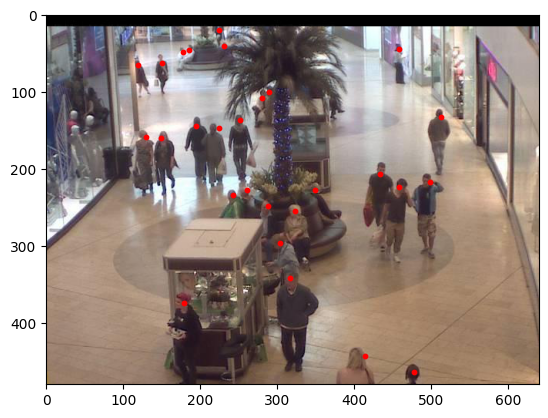

In [31]:
plot_frame(1950)